In [22]:
import math
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from collections import Counter, defaultdict
import pandas as pd
import pickle
import numpy as np
from shapely.geometry import Polygon, Point, LinearRing, box
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn import linear_model, decomposition
from sklearn.feature_extraction import DictVectorizer
%matplotlib notebook

In [131]:
df_train = pd.read_pickle('df_train')
df_test = pd.read_pickle('df_test')
# x_train_df = pd.read_pickle('x_train_df')
# x_test_df = pd.read_pickle('x_test_df')

In [3]:
min_x_entry = min(min(df_train.x_entry.describe()['min'], df_test.x_entry.describe()['min']),
                  df_train.x_exit.describe()['min'])
min_y_entry = min(min(df_train.y_entry.describe()['min'], df_test.y_entry.describe()['min']),
                  df_train.y_exit.describe()['min'])
max_x_entry = max(max(df_train.x_entry.describe()['max'], df_test.x_entry.describe()['max']),
                  df_train.x_exit.describe()['max'])
max_y_entry = max(max(df_train.y_entry.describe()['max'], df_test.y_entry.describe()['max']),
                  df_train.y_exit.describe()['max'])
print(min_x_entry, max_x_entry, min_y_entry, max_y_entry)

3740998.35481912 3777099.2656833767 -19382914.9809002 -19042656.658487003


In [ ]:
def plot_map():
    rect_all = patches.Rectangle((3740998.35481912, -19042656.658487003), (3777099.2656833767 - 3740998.35481912),
                             (- 19382914.9809002 + 19042656.658487003),
                             linewidth=1,edgecolor='g',fill = False,hatch = '\\\\\\', label = 'city')
    city = plt.gca().add_patch(rect_all)
    rect_city = patches.Rectangle((3750901.5068, -19208905.6133), (3770901.5068 - 3750901.5068),
                             (- 19268905.6133 + 19208905.6133),
                             linewidth=1,edgecolor='r',fill = False,hatch = '//////', label = 'city center')
    city_center = plt.gca().add_patch(rect_city)
    plt.legend(handles=[city, city_center])
    plt.grid(True)
#     plt.xlim(min_x_entry, max_x_entry)
    plt.ylim(min_y_entry, max_y_entry)
    plt.xlim(3740000, 3780000)
    plt.ylim(-19000000, - 19400000)
    plt.show()

In [ ]:
def get_box(x,y):
    n1 = -1
    n2 = -1
    if(~np.isnan(x) and ~np.isnan(y)):
        if(x >= 3740000.0000000000 and x < 3745000.0000000000):
            n1 = 1
        elif(x >= 3745000.0000000000 and x < 3750000.0000000000):
            n1 = 2
        elif(x >= 3750000.0000000000 and x < 3755000.0000000000):
            n1 = 3
        elif(x >= 3755000.0000000000 and x < 3760000.0000000000):
            n1 = 4
        elif(x >= 3760000.0000000000 and x < 3765000.0000000000):
            n1 = 5
        elif(x >= 3765000.0000000000 and x < 3770000.0000000000):
            n1 = 6
        elif(x >= 3770000.0000000000 and x < 3775000.0000000000):
            n1 = 7
        else:
            n1 = 8

        if(y >= -19400000.0000000000 and y < -19350000.0000000000):
            n2 = 8
        elif(y >= -19350000.0000000000 and y < -19300000.0000000000):
            n2 = 7
        elif(y >= -19300000.0000000000 and y < -19250000.0000000000):
            n2 = 6
        elif(y >= -19250000.0000000000 and y < -19200000.0000000000):
            n2 = 5
        elif(y >= -19200000.0000000000 and y < -19150000.0000000000):
            n2 = 4
        elif(y >= -19150000.0000000000 and y < -19100000.0000000000):
            n2 = 3
        elif(y >= -19100000.0000000000 and y < -19050000.0000000000):
            n2 = 2
        else:
            n2 = 1
    
        return (n2-1)*8 + n1
    else:
        return 0

In [ ]:
df_test['distance'] = df_test.apply(lambda row: Point(row['x_entry'],row['y_entry']).
                                      distance(Point(row['x_exit'],row['y_exit'])) if ~np.isnan(row['x_exit'])
                                     else np.nan, axis=1)
df_test['velocity'] = df_test.apply(lambda row: (row['distance']/row['duration'])
                                      if (row['duration']!= 0.0 and ~np.isnan(row['x_exit'])) else 0.0, axis=1)
df_train['entry_box'] = df_train.apply(lambda row: get_box(row['x_entry'], row['y_entry']) , axis=1)
df_train['exit_box'] = df_train.apply(lambda row: get_box(row['x_exit'], row['y_exit']) , axis=1)
df_test['entry_box'] = df_test.apply(lambda row: get_box(row['x_entry'], row['y_entry']) , axis=1)
df_test['exit_box'] = df_test.apply(lambda row: get_box(row['x_exit'], row['y_exit']) , axis=1)

In [ ]:
df_train.to_pickle('df_train')
df_test.to_pickle('df_test')

In [4]:
df = df_train.groupby('hash')
df_list = list(df)

In [5]:
df_test = df_test.groupby('hash')
df_test_list = list(df_test)

In [81]:
dataset = []
print(len(df_list))
for index, sample in enumerate(df_list):
    length = sample[1].shape[0]
    count = 0
    features = {}
    features['hash'] = sample[0]
    for index1, row in sample[1].iterrows():
        features['trajectory_id']  = row['trajectory_id']
        if(count < length - 1):
            features['entry_'+ str(row['entry_box'])]  = features.get('entry_'+ str(row['entry_box']),0) + 1
            features['exit_' + str(row['exit_box'])]  = features.get('exit_'+ str(row['exit_box']),0) + 1
#             features['entry_time_'+ str(int(row['time_entry'] / np.timedelta64(1, 'h')))] = features.get('entry_time_'+ str(int(row['time_entry'] / np.timedelta64(1, 'h'))),0) + 1
#             features['exit_time_'+ str(int(row['time_exit'] / np.timedelta64(1, 'h')))] = features.get('exit_time_'+ str(int(row['time_entry'] / np.timedelta64(1, 'h'))),0) + 1
        else:
            features['l_entry']  = row['entry_box']
            features['l_exit']  = row['exit_box']
            features['x_entry'] = row['x_entry']
            features['y_entry'] = row['y_entry']
            features['duration'] = row['duration']
            features['city_distance'] = row['city_distance']
            features['hour'] = row['hour']
            features['label'] = row['label']
        count = count + 1
    dataset.append(features)

134063


KeyboardInterrupt: 

In [ ]:
test_dataset = []
print(len(df_test_list))
for index, sample in enumerate(df_test_list):
    length = sample[1].shape[0]
    count = 0
    features = {}
    features['hash'] = sample[0]
    for index1, row in sample[1].iterrows():
        features['trajectory_id']  = row['trajectory_id']
        if(count < length - 1):
            features['entry_'+ str(row['entry_box'])]  = features.get('entry_'+ str(row['entry_box']),0) + 1
            features['exit_' + str(row['exit_box'])]  = features.get('exit_'+ str(row['exit_box']),0) + 1
#             features['entry_time_'+ str(int(row['time_entry'] / np.timedelta64(1, 'h')))] = features.get('entry_time_'+ str(int(row['time_entry'] / np.timedelta64(1, 'h'))),0) + 1
#             features['exit_time_'+ str(int(row['time_exit'] / np.timedelta64(1, 'h')))] = features.get('exit_time_'+ str(int(row['time_entry'] / np.timedelta64(1, 'h'))),0) + 1
        else:
            features['l_entry']  = row['entry_box']
            features['l_exit']  = 0
            features['x_entry'] = row['x_entry']
            features['y_entry'] = row['y_entry']
            features['duration'] = row['duration']
            features['city_distance'] = row['city_distance']
            features['hour'] = row['hour']
            features['label'] = -1
        count = count + 1
    test_dataset.append(features)

In [59]:
x_train_df = pd.DataFrame(dataset).fillna(0)

In [60]:
x_test_df = pd.DataFrame(test_dataset).fillna(0)
x_test_df['entry_5'] = 0.0
x_test_df['exit_5'] = 0.0

In [61]:
print(x_train_df.shape, x_test_df.shape)

(134063, 148) (33515, 148)


In [62]:
x_train_df.to_pickle('x_train_df')
x_test_df.to_pickle('x_test_df')

In [82]:
x_train_df = pd.read_pickle('x_train_df_1')
x_test_df = pd.read_pickle('x_test_df_1')

In [83]:
training_dataset = x_train_df.drop(['hash','l_exit','trajectory_id'], axis=1)
testing_dataset = x_test_df.drop(['hash','l_exit','trajectory_id'], axis=1)

In [84]:
x_1 = training_dataset.drop(['label'], axis=1).values
y_1 = training_dataset['label'].values
sc_1 = StandardScaler()
x_1 = sc_1.fit_transform(x_1)

In [ ]:
pca = decomposition.PCA()
pca.fit(x_1)
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.axes([.2, .2, .7, .7])
plt.plot(pca.explained_variance_, linewidth=2)
plt.axis('tight')
plt.xlabel('n_components')
plt.ylabel('explained_variance_')


In [27]:
x_1 = pca.transform(x_1)

In [85]:
xTrain, xTest, yTrain, yTest = train_test_split(x_1, y_1, test_size = 0.0, random_state = 0)
clf_1 = RandomForestClassifier(n_jobs = -1, n_estimators = 500, max_depth = 60, random_state=42)
# clf_1 = GaussianNB()
# clf_1 = AdaBoostClassifier(n_estimators=100)
# clf_1 = SVC(gamma=2, C=1)
# clf_1 = MLPClassifier(activation= 'relu',hidden_layer_sizes=(10,10,10))
# clf_1 = GaussianProcessClassifier(1.0 * RBF(1.0))
# clf_1 = LogisticRegression(penalty ='l2',dual = True)
# clf_1 = DecisionTreeClassifier(max_depth=1000)
# clf_1 = KNeighborsClassifier(3)
clf_1.fit(xTrain, yTrain)
# yPred = clf_1.predict(xTest)
# print(classification_report(yTest, yPred))

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=60, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

In [ ]:
rf = RandomForestClassifier()
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(xTrain, yTrain)
rf_random.best_params_

In [ ]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [80, 90, 100, 110],
    'max_features': [2, 3],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 200, 300, 1000]
}
# Create a based model
rf = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)
# Fit the grid search to the data
grid_search.fit(train_features, train_labels)
grid_search.best_params_
best_grid = grid_search.best_estimator_

In [86]:
x_test_df['label'] =  clf_1.predict(sc_1.fit_transform(testing_dataset.drop(['label'], axis=1).values))

In [87]:
x_test_df['label'] = x_test_df.apply(lambda row: 0 
                                 if ((row['duration'] == 0.0) &
                                     ~(((row['x_entry'] >= 3750901.5068) &
                                                               (row['x_entry'] <= 3770901.5068)) &
                                       ((row['y_entry'] >= -19268905.6133) &
                                        (row['y_entry'] <= -19208905.6133))))
                                 else row['label'], axis=1)
x_test_df['label'] = x_test_df.apply(lambda row: 1
                                 if ((row['duration'] == 0.0) &
                                     (((row['x_entry'] >= 3750901.5068) &
                                                               (row['x_entry'] <= 3770901.5068)) &
                                       ((row['y_entry'] >= -19268905.6133) &
                                        (row['y_entry'] <= -19208905.6133))))
                                 else row['label'], axis=1)

In [98]:
x_test_df.label.value_counts()

0    25249
1     8266
Name: label, dtype: int64

In [70]:
x_test_df.sort_values('trajectory_id',ascending=True)[['trajectory_id','label']].to_csv('output30.csv', index=False)

In [89]:
test_start_not_in_city = x_test_df[~(((x_test_df['x_entry'] >= 3750901.5068) &
         (x_test_df['x_entry'] <= 3770901.5068)) & ((x_test_df['y_entry'] >= -19268905.6133) &
         (x_test_df['y_entry'] <= -19208905.6133)))]
test_start_in_city = x_test_df[((x_test_df['x_entry'] >= 3750901.5068) &
         (x_test_df['x_entry'] <= 3770901.5068)) & ((x_test_df['y_entry'] >= -19268905.6133) &
         (x_test_df['y_entry'] <= -19208905.6133))]

In [90]:
test_start_not_in_city.label.value_counts()

0    23947
1       24
Name: label, dtype: int64

In [99]:
test_start_not_in_city.shape

(23971, 118)

In [100]:
test_start_in_city.shape

(9544, 118)

In [101]:
23971 + 9544

33515

In [102]:
test_start_in_city.label.value_counts()

1    8242
0    1302
Name: label, dtype: int64

In [127]:
x = test_start_not_in_city[(test_start_not_in_city['duration'] != 0.0)&(test_start_not_in_city['label'] == 1)][['hash','duration','city_distance','hour']].hash.values

In [135]:
df_test.loc[df_test['hash'].isin(x)][df_test.x_exit.isnull()]

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Unnamed: 0,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,...,duration,city_distance,ratio,label,hour,count,entry_box,exit_box,distance,velocity
3924,3924,04ef7051de0e9c4ecdfca7faaf79a16c_29,traj_04ef7051de0e9c4ecdfca7faaf79a16c_29_9,15:57:36,15:59:17,NaN,NaN,NaN,3.759574e+06,-1.920887e+07,...,101.0,38.833115,0.384486,-1,15.960000,4,36,0,NaN,0.0
15919,15919,13b23c1aa0494788684295ae0d6f5a68_29,traj_13b23c1aa0494788684295ae0d6f5a68_29_7,14:58:03,15:03:14,NaN,NaN,NaN,3.764834e+06,-1.920880e+07,...,311.0,106.862067,0.343608,-1,14.967500,7,37,0,NaN,0.0
19013,19013,17c9699ce1297df47543468185a09670_9,traj_17c9699ce1297df47543468185a09670_9_20,14:52:30,15:02:37,NaN,NaN,NaN,3.759808e+06,-1.920872e+07,...,607.0,186.228265,0.306801,-1,14.875000,10,36,0,NaN,0.0
26724,26724,213ace852322a3a297eacf36140c94ae_29,traj_213ace852322a3a297eacf36140c94ae_29_9,15:14:24,15:19:17,NaN,NaN,NaN,3.751318e+06,-1.926895e+07,...,293.0,39.649251,0.135322,-1,15.240000,8,43,0,NaN,0.0
43264,43264,362119bb0a341aec0f440e6f641f5bc9_23,traj_362119bb0a341aec0f440e6f641f5bc9_23_50,15:02:08,15:11:34,NaN,NaN,NaN,3.763847e+06,-1.920882e+07,...,566.0,84.185830,0.148738,-1,15.035556,12,37,0,NaN,0.0
56824,56824,478865ee1a14976f97a52c22691441be_9,traj_478865ee1a14976f97a52c22691441be_9_9,15:18:00,15:19:16,NaN,NaN,NaN,3.771019e+06,-1.924287e+07,...,76.0,117.488296,1.545899,-1,15.300000,7,39,0,NaN,0.0
57198,57198,47f71e5ace8824be78464112c1f73fb5_19,traj_47f71e5ace8824be78464112c1f73fb5_19_15,15:01:11,15:07:50,NaN,NaN,NaN,3.764743e+06,-1.920881e+07,...,399.0,95.523959,0.239408,-1,15.019722,7,37,0,NaN,0.0
63342,63342,4fd07d2d85cfac82ef2ee5a86a47288e_25,traj_4fd07d2d85cfac82ef2ee5a86a47288e_25_20,14:44:46,15:33:24,NaN,NaN,NaN,3.750897e+06,-1.921951e+07,...,2918.0,4.622860,0.001584,-1,14.746111,12,35,0,NaN,0.0
67389,67389,5500b97b6ff43ef35b3b4220bca1b055_19,traj_5500b97b6ff43ef35b3b4220bca1b055_19_3,14:56:41,15:01:47,NaN,NaN,NaN,3.765606e+06,-1.920888e+07,...,306.0,27.494887,0.089853,-1,14.944722,3,38,0,NaN,0.0
69949,69949,5823ed31d7dc2e60bddaba95a73503e6_31,traj_5823ed31d7dc2e60bddaba95a73503e6_31_6,15:41:08,15:48:27,NaN,NaN,NaN,3.770933e+06,-1.922152e+07,...,439.0,31.772288,0.072374,-1,15.685556,6,39,0,NaN,0.0


In [136]:
y = test_start_in_city[(test_start_in_city['duration'] != 0.0)&(test_start_in_city['label'] == 0)][['hash','duration','city_distance','hour']].hash.values

In [140]:
df_test.loc[df_test['hash'].isin(y)][df_test.x_exit.isnull()].sort_values('time_exit')

C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,Unnamed: 0,hash,trajectory_id,time_entry,time_exit,vmax,vmin,vmean,x_entry,y_entry,...,duration,city_distance,ratio,label,hour,count,entry_box,exit_box,distance,velocity
39778,39778,31a14827248d045c561dc13aa9355985_15,traj_31a14827248d045c561dc13aa9355985_15_11,14:11:01,15:00:01,NaN,NaN,NaN,3.766527e+06,-1.922769e+07,...,2940.0,-4374.253157,-1.487841,-1,14.183611,7,38,0,NaN,0.0
22251,22251,1ba15ada11742c041a7ca240d0de0908_3,traj_1ba15ada11742c041a7ca240d0de0908_3_17,14:38:56,15:00:01,NaN,NaN,NaN,3.757783e+06,-1.923294e+07,...,1265.0,-6881.600841,-5.440001,-1,14.648889,15,36,0,NaN,0.0
131343,131343,a54f959f40277fbf24d817317eb4fce2_5,traj_a54f959f40277fbf24d817317eb4fce2_5_2,14:44:09,15:00:02,NaN,NaN,NaN,3.758562e+06,-1.924230e+07,...,953.0,-7660.837276,-8.038654,-1,14.735833,2,36,0,NaN,0.0
8480,8480,0a9d893fa3958a245770e96ea0ab9818_19,traj_0a9d893fa3958a245770e96ea0ab9818_19_30,14:30:38,15:00:02,NaN,NaN,NaN,3.758402e+06,-1.923014e+07,...,1764.0,-7500.537210,-4.252005,-1,14.510556,12,36,0,NaN,0.0
148403,148403,bb1ba94473302bc3af5e40b7692772ae_29,traj_bb1ba94473302bc3af5e40b7692772ae_29_12,14:20:37,15:00:03,NaN,NaN,NaN,3.767406e+06,-1.926412e+07,...,2366.0,-3495.942375,-1.477575,-1,14.343611,9,46,0,NaN,0.0
37811,37811,2f549ab53837a0491ead6e11ed6030cd_5,traj_2f549ab53837a0491ead6e11ed6030cd_5_4,14:42:58,15:00:04,NaN,NaN,NaN,3.760448e+06,-1.923344e+07,...,1026.0,-9546.589451,-9.304668,-1,14.716111,4,37,0,NaN,0.0
161579,161579,cb84ac86f9bb78a81b71ef77d52debaa_31,traj_cb84ac86f9bb78a81b71ef77d52debaa_31_10,14:41:26,15:00:06,NaN,NaN,NaN,3.768990e+06,-1.922007e+07,...,1120.0,-1911.866021,-1.707023,-1,14.690556,9,38,0,NaN,0.0
83365,83365,69cf337ca9495edd4c3ca3c6bb288490_23,traj_69cf337ca9495edd4c3ca3c6bb288490_23_4,14:35:29,15:00:08,NaN,NaN,NaN,3.760316e+06,-1.923001e+07,...,1479.0,-9414.119256,-6.365192,-1,14.591389,3,37,0,NaN,0.0
180402,180402,e421eddcb97cbea929ce9f1f4ce672f0_25,traj_e421eddcb97cbea929ce9f1f4ce672f0_25_5,14:46:32,15:00:09,NaN,NaN,NaN,3.751509e+06,-1.924181e+07,...,817.0,-607.634340,-0.743738,-1,14.775556,4,35,0,NaN,0.0
33545,33545,29f2af1c4f6e14a536adab14191aa9a7_29,traj_29f2af1c4f6e14a536adab14191aa9a7_29_17,14:02:37,15:00:11,NaN,NaN,NaN,3.758042e+06,-1.923315e+07,...,3454.0,-7140.975254,-2.067451,-1,14.043611,15,36,0,NaN,0.0


In [162]:
def plot_row(row):
    rect = patches.Rectangle((3750901.5068,-19208905.6133), (3770901.5068 - 3750901.5068),
                             (- 19268905.6133 + 19208905.6133),
                             linewidth=1,edgecolor='g',fill = False, label = 'city center')
    city = plt.gca().add_patch(rect)
    arrows = plt.plot([row['x_entry'], row['x_exit']], [row['y_entry'], row['y_exit']], color = 'b')
    entries = plt.scatter(row['x_entry'],row['y_entry'], label='Entry point', color = 'b')
    exits = plt.scatter(row['x_exit'],row['y_exit'], label='Exit point', color = 'r')
    plt.legend(handles=[city,entries, exits])
    plt.grid(True)
    plt.show()

<IPython.core.display.Javascript object>


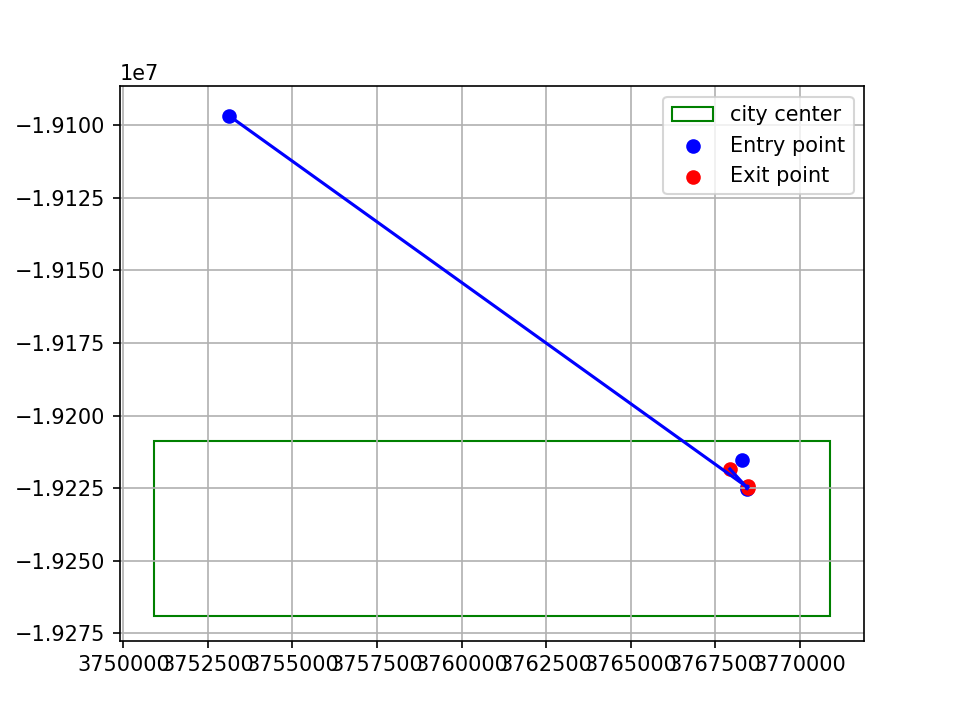

In [166]:
plot_row(df_test[df_test['hash'] == '726ca607cd4197a8e33eafc8de6862bf_23'])